In [270]:
# import modules
import pandas as pd
import numpy as np
import os
from openpyxl import load_workbook
from pathlib import Path

from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb

import warnings

warnings.filterwarnings("ignore", message="DrawingML support is incomplete")

# Work on Crime and Clearances, and Pop and Area (Compeleted)

In [271]:
# DataFrame for Crimes and clearances with Arson
crime_clearance_df = pd.read_csv(
    "../data/Crimes_and_Clearances_with_Arson-1985-2023.csv"
)

C:\Users\leoaf\AppData\Local\Temp\ipykernel_28832\1413198914.py:2: DtypeWarning: Columns (21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_clearance_df = pd.read_csv(


The message above indicates that some of the columns have mixed data type. We can resolve this below:
- First check which columns have non-numeric data types.
- Check which columns have mixed data types. 

In [272]:
## Columns with Non numeric dtypes
non_numeric_cols = crime_clearance_df.select_dtypes(include=["object"]).columns
print(non_numeric_cols)

Index(['County', 'NCICCode', 'TotalStructural_sum', 'TotalMobile_sum',
       'TotalOther_sum', 'GrandTotal_sum', 'GrandTotClr_sum'],
      dtype='object')


In [273]:
def mixed_type_columns(df: pd.DataFrame) -> list:
    """
    Look for columns with mixed types

    Parameters:
    df(pd.DataFrame)

    Returns:
    list: A list of columes with mixed dtypes
    """
    mixed_columns = []
    for column in df.columns:
        types_in_column = df[column].map(type).unique()
        if len(types_in_column) > 1:
            mixed_columns.append(column)
    return mixed_columns

In [274]:
# The columns with mixed dtypes
mixed_columns = mixed_type_columns(crime_clearance_df)
print(mixed_columns)

['TotalStructural_sum', 'TotalMobile_sum', 'TotalOther_sum', 'GrandTotal_sum', 'GrandTotClr_sum']


In [275]:
cca_df = crime_clearance_df.copy()  # A copy of crime_clearance_df

# Resolve the issue with mixed dtypes
cca_df[mixed_columns] = cca_df[mixed_columns].apply(pd.to_numeric, errors="coerce")

In [276]:
# No mixed types in the copy of the dataframe.
mixed_columns = mixed_type_columns(cca_df)
print(mixed_columns == [])

True


In [277]:
# Remove the column
cca_df = cca_df.drop(["NCICCode"], axis=1)
cca_df.head(3)

Year          County  Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
0  1985  Alameda County          427             3           27          166   
1  1985  Alameda County          405             7           15          220   
2  1985  Alameda County          101             1            4           58   

   AggAssault_sum  Property_sum  Burglary_sum  VehicleTheft_sum  ...  \
0             231          3964          1483               353  ...   
1             163          4486           989               260  ...   
2              38           634           161                55  ...   

   MVPLARnao_sum  BILARnao_sum  FBLARnao_sum  COMLARnao_sum  AOLARnao_sum  \
0            109           205            44             11           475   
1            673           516           183             53           559   
2             62            39            46             17            37   

   LT400nao_sum  LT200400nao_sum  LT200nao_sum  LT50200nao_sum  LT50nao_sum  
0         753.0            437.0           NaN             440          498  
1         540.0            622.0           NaN             916         1159  
2          84.0             68.0           NaN             128          138  

[3 rows x 69 columns]

In [278]:
# Custom function to remove County from the values in the column County
def remove_county(text: str) -> str:
    """
    Remove County from string
    """
    return text.replace(" County", "")


assert remove_county("Hello County") == "Hello"
assert remove_county("Hello World County") == "Hello World"

In [279]:
# Apply the remove_county to the dataframe cca_df
cca_df["County"] = cca_df["County"].apply(remove_county)
cca_df["Year"] = cca_df["Year"].astype(str)

# Group by 'County' and 'Year'
cca_grouped_df = cca_df.groupby(["County", "Year"]).sum()

In [280]:
cca_grouped_df.head(3)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   

              AggAssault_sum  Property_sum  Burglary_sum  VehicleTheft_sum  \
County  Year                                                                 
Alameda 1985            5267         89297         24997              7142   
        1986            5530         90167         24392              7896   
        1987            5767         88306         22399              8909   

              LTtotal_sum  ViolentClr_sum  ...  MVPLARnao_sum  BILARnao_sum  \
County  Year                               ...                                
Alameda 1985        57158            5429  ...           5728          3926   
        1986        57879            5570  ...           5449          3380   
        1987        56998            6303  ...           5445          2954   

              FBLARnao_sum  COMLARnao_sum  AOLARnao_sum  LT400nao_sum  \
County  Year                                                            
Alameda 1985         10664            406          9163        7744.0   
        1986          9575            465          9552        9048.0   
        1987          8687            256          8817       11437.0   

              LT200400nao_sum  LT200nao_sum  LT50200nao_sum  LT50nao_sum  
County  Year                                                              
Alameda 1985           7787.0           0.0           14473        27154  
        1986           7482.0           0.0           13459        27890  
        1987           8132.0           0.0           10845        26584  

[3 rows x 67 columns]

In [281]:
# Create a new feature 'crime_rate' for each county and year: crime_rate = Violentsum/poplation
violent = [
    "Violent_sum",
    "Homicide_sum",
    "ForRape_sum",
    "Robbery_sum",
    "AggAssault_sum",
    "ViolentClr_sum",
    "HomicideClr_sum",
    "ForRapeClr_sum",
    "RobberyClr_sum",
    "AggAssaultClr_sum",
]

property = [
    "Property_sum",
    "Burglary_sum",
    "VehicleTheft_sum",
    "LTtotal_sum",
    "PropertyClr_sum",
    "BurglaryClr_sum",
    "VehicleTheftClr_sum",
    "LTtotalClr_sum",
]

In [282]:
crime_data = cca_grouped_df[violent + property]
crime_data.head()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   

              RobberyClr_sum  AggAssaultClr_sum  Property_sum  Burglary_sum  \
County  Year                                                                  
Alameda 1985            1517               3376         89297         24997   
        1986            1545               3379         90167         24392   
        1987            1569               4132         88306         22399   
        1988            1545               3565         92745         22308   
        1989            1496               3203         92888         21311   

              VehicleTheft_sum  LTtotal_sum  PropertyClr_sum  BurglaryClr_sum  \
County  Year                                                                    
Alameda 1985              7142        57158            15409             3117   
        1986              7896        57879            15121             2899   
        1987              8909        56998            16380             2848   
        1988             11080        59357            16747             2671   
        1989             12556        59021            16171             2539   

              VehicleTheftClr_sum  LTtotalClr_sum  
County  Year                                       
Alameda 1985                 1607           10685  
        1986                 1698           10524  
        1987                 2189           11343  
        1988                 2533           11543  
        1989                 2560           11072

In [283]:
# DataFrame for Pop and area by county
pop_area = pd.read_csv("../data/Pop_and_area_by_county_1980_to_2024.csv")

In [284]:
pop_area = pop_area.rename(columns={"COUNTY": "County", "Area (sq mi)": "Area_sq_mi"})
pop_area_copy = pop_area.copy()  # Make a copy
pop_area_copy.head(3)

County  Area_sq_mi       1981       1982       1983  \
0  Alameda                    738.0  1,117,800  1,134,000  1,151,800   
1  Alpine                     739.0      1,090      1,100      1,120   
2  Amador                     606.0     19,800     20,250     20,600   

        1984       1985       1986       1987       1988  ...       2015  \
0  1,170,400  1,185,500  1,206,900  1,220,600  1,242,300  ...  1,622,205   
1      1,080      1,100      1,140      1,130      1,100  ...      1,190   
2     21,050     21,800     22,450     23,300     25,750  ...     37,453   

        2016       2017       2018       2019       2020       2021  \
0  1,641,983  1,656,919  1,666,247  1,675,964  1,681,337  1,655,767   
1      1,196      1,201      1,205      1,201      1,204      1,181   
2     37,663     38,807     39,708     40,227     40,426     40,224   

        2022       2023       2024  
0  1,645,265  1,644,199  1,644,569  
1      1,177      1,166      1,163  
2     40,073     40,028     39,893  

[3 rows x 46 columns]

In [285]:
pop_area_copy = pop_area_copy.drop(["Area_sq_mi"], axis=1)
pop_area_copy["County"] = pop_area_copy["County"].apply(lambda x: str(x.strip()))
pop_area_copy.head()

County       1981       1982       1983       1984       1985  \
0    Alameda  1,117,800  1,134,000  1,151,800  1,170,400  1,185,500   
1     Alpine      1,090      1,100      1,120      1,080      1,100   
2     Amador     19,800     20,250     20,600     21,050     21,800   
3      Butte    146,800    150,700    153,800    156,600    159,700   
4  Calaveras     21,350     22,250     23,200     23,850     24,650   

        1986       1987       1988       1989  ...       2015       2016  \
0  1,206,900  1,220,600  1,242,300  1,261,200  ...  1,622,205  1,641,983   
1      1,140      1,130      1,100      1,090  ...      1,190      1,196   
2     22,450     23,300     25,750     27,600  ...     37,453     37,663   
3    163,000    166,200    170,800    175,200  ...    227,400    228,198   
4     25,550     26,800     28,200     29,700  ...     45,395     45,402   

        2017       2018       2019       2020       2021       2022  \
0  1,656,919  1,666,247  1,675,964  1,681,337  1,655,767  1,645,265   
1      1,201      1,205      1,201      1,204      1,181      1,177   
2     38,807     39,708     40,227     40,426     40,224     40,073   
3    230,412    231,774    227,263    216,090    206,058    206,183   
4     45,355     45,367     45,324     45,290     45,013     44,771   

        2023       2024  
0  1,644,199  1,644,569  
1      1,166      1,163  
2     40,028     39,893  
3    205,741    206,194  
4     44,616     44,436  

[5 rows x 45 columns]

In [286]:
# Convert pop_area_copy to the structure of crime_data
pop_index_county = pop_area_copy.set_index("County")  # Index dataframe by County
pop_stacked = pop_index_county.stack().to_frame(name="popupation")
pop_stacked["popupation"] = pop_stacked["popupation"].apply(
    lambda x: int(str(x.replace(",", "")))
)
pop_stacked.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2596 entries, ('Alameda', '1981') to ('State Total', '2024')
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   popupation  2596 non-null   int64
dtypes: int64(1)
memory usage: 29.3+ KB


In [287]:
# Create Column for Population and Area_sq

crime_data_df = crime_data.copy()
crime_data_df["Population"] = pop_stacked[
    "popupation"
]  # Add column 'Population' to crime_data_df

area_df = pop_area.copy()
area_df = area_df[["County", "Area_sq_mi"]]
area_df["County"] = area_df["County"].apply(lambda x: str(x.strip()))

crime_data_df = crime_data_df.reset_index()  # Reset the index
crime_data_df = crime_data_df.merge(area_df, on="County", how="left")
crime_data_df = crime_data_df.set_index(["County", "Year"])

In [288]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  Property_sum  Burglary_sum  \
County Year                                                                  
Yuba   2019              13                107          1844           405   
       2020              26                128          1841           318   
       2021              21                112          1284           242   
       2022              18                 92          1227           302   
       2023              14                 93           828           264   

             VehicleTheft_sum  LTtotal_sum  PropertyClr_sum  BurglaryClr_sum  \
County Year                                                                    
Yuba   2019               475          964              121               45   
       2020               623          900              101               31   
       2021               293          749              110               28   
       2022               131          794               84               19   
       2023               144          420               88               35   

             VehicleTheftClr_sum  LTtotalClr_sum  Population  Area_sq_mi  
County Year                                                               
Yuba   2019                   15              61       79619       630.0  
       2020                   23              47       81178       630.0  
       2021                   42              40       82091       630.0  
       2022                   25              40       82563       630.0  
       2023                   16              37       83405       630.0

In [289]:
crime_data_df.loc[("Yuba", "2021")]

Violent_sum              354.0
Homicide_sum               6.0
ForRape_sum               35.0
Robbery_sum               70.0
AggAssault_sum           243.0
ViolentClr_sum           149.0
HomicideClr_sum            7.0
ForRapeClr_sum             9.0
RobberyClr_sum            21.0
AggAssaultClr_sum        112.0
Property_sum            1284.0
Burglary_sum             242.0
VehicleTheft_sum         293.0
LTtotal_sum              749.0
PropertyClr_sum          110.0
BurglaryClr_sum           28.0
VehicleTheftClr_sum       42.0
LTtotalClr_sum            40.0
Population             82091.0
Area_sq_mi               630.0
Name: (Yuba, 2021), dtype: float64

## Computing some possible features
- Crime rate
- Claerance rate
- Population density

In [290]:
crime_data_df.loc[("Yuba", "2021")]

Violent_sum              354.0
Homicide_sum               6.0
ForRape_sum               35.0
Robbery_sum               70.0
AggAssault_sum           243.0
ViolentClr_sum           149.0
HomicideClr_sum            7.0
ForRapeClr_sum             9.0
RobberyClr_sum            21.0
AggAssaultClr_sum        112.0
Property_sum            1284.0
Burglary_sum             242.0
VehicleTheft_sum         293.0
LTtotal_sum              749.0
PropertyClr_sum          110.0
BurglaryClr_sum           28.0
VehicleTheftClr_sum       42.0
LTtotalClr_sum            40.0
Population             82091.0
Area_sq_mi               630.0
Name: (Yuba, 2021), dtype: float64

In [291]:
crime_data_df.tail(3)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  Property_sum  Burglary_sum  \
County Year                                                                  
Yuba   2021              21                112          1284           242   
       2022              18                 92          1227           302   
       2023              14                 93           828           264   

             VehicleTheft_sum  LTtotal_sum  PropertyClr_sum  BurglaryClr_sum  \
County Year                                                                    
Yuba   2021               293          749              110               28   
       2022               131          794               84               19   
       2023               144          420               88               35   

             VehicleTheftClr_sum  LTtotalClr_sum  Population  Area_sq_mi  
County Year                                                               
Yuba   2021                   42              40       82091       630.0  
       2022                   25              40       82563       630.0  
       2023                   16              37       83405       630.0

# Work on Unemployment (Completed)

In [292]:
# DataFrame for Unemployment rate
unemployment_rate_df = pd.read_excel("../data/Unemployment_rate_1990-2023.xlsx")

In [293]:
unemployment_rate_df = unemployment_rate_df.rename(
    columns={
        "County Name/State Abbreviation": "County",
        "unemployment rate(%)": "unemployment_rate",
    }
)
unemployment_rate_df.head()

Code  Code.1  Code.2                County  Year  Unnamed: 5  \
0  CN0600100000000       6       1    Alameda County, CA  2023         NaN   
1  CN0600300000000       6       3     Alpine County, CA  2023         NaN   
2  CN0600500000000       6       5     Amador County, CA  2023         NaN   
3  CN0600700000000       6       7      Butte County, CA  2023         NaN   
4  CN0600900000000       6       9  Calaveras County, CA  2023         NaN   

   Laber Force  Employed  Unemployed  unemployment_rate  
0       826102    792439       33663                4.1  
1          540       505          35                6.5  
2        14404     13673         731                5.1  
3        91910     87088        4822                5.2  
4        21956     21030         926                4.2

In [294]:
unemployment_rate_df["County"] = unemployment_rate_df["County"].apply(
    lambda x: x.replace(" County, CA", "").replace(" County/city, CA", "")
)
unemp_rate_df = unemployment_rate_df.copy()
# unemp_rate_df = unemp_rate_df.fillna(0)
unemp_rate_df = unemp_rate_df[["County", "Year", "unemployment_rate"]]
unemp_rate_df["Year"] = unemp_rate_df["Year"].astype(str)
unemp_rate_df.set_index(["County", "Year"], inplace=True)

In [295]:
unemp_rate_df.tail()

unemployment_rate
County   Year                   
Tulare   1993               18.2
Tuolumne 1993               11.9
Ventura  1993                9.1
Yolo     1993                8.1
Yuba     1993               17.5

In [296]:
crime_data_df = crime_data_df.merge(
    unemp_rate_df, left_index=True, right_index=True, how="left"
)

In [297]:
crime_data_df.tail(5)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  Burglary_sum  \
County Year                                     ...                 
Yuba   2019              13                107  ...           405   
       2020              26                128  ...           318   
       2021              21                112  ...           242   
       2022              18                 92  ...           302   
       2023              14                 93  ...           264   

             VehicleTheft_sum  LTtotal_sum  PropertyClr_sum  BurglaryClr_sum  \
County Year                                                                    
Yuba   2019               475          964              121               45   
       2020               623          900              101               31   
       2021               293          749              110               28   
       2022               131          794               84               19   
       2023               144          420               88               35   

             VehicleTheftClr_sum  LTtotalClr_sum  Population  Area_sq_mi  \
County Year                                                                
Yuba   2019                   15              61       79619       630.0   
       2020                   23              47       81178       630.0   
       2021                   42              40       82091       630.0   
       2022                   25              40       82563       630.0   
       2023                   16              37       83405       630.0   

             unemployment_rate  
County Year                     
Yuba   2019                6.2  
       2020               10.6  
       2021                8.4  
       2022                5.6  
       2023                6.7  

[5 rows x 21 columns]

# Work on Median household income and CPI (Completed)

In [298]:
# DataFrame for Califonia_CPI
califonia_cpi_df = pd.read_excel("../data/California_CPI_1985_to_2023.xlsx")

# DataFrame for median household income
median_house_income = pd.read_excel("../data/Median_income_2000_and_2009_to_2023.xlsx")

In [299]:
califonia_cpi_df["Year"] = califonia_cpi_df["Year"].astype(str)
median_house_income["Year"] = median_house_income["Year"].astype(str)

In [300]:
median_house_cpi = median_house_income.merge(califonia_cpi_df, on="Year", how="left")
median_house_cpi["County"] = median_house_cpi["County"].apply(
    lambda x: x.replace(" County", "").strip()
)
median_house_cpi = median_house_cpi.rename(
    columns={"Median Household Income": "median_household_income"}
)
median_house_cpi = median_house_cpi.set_index(["County", "Year"])
median_house_cpi["median_household_income"] = median_house_cpi[
    "median_household_income"
].astype("float64")

In [301]:
median_house_cpi.head()

median_household_income      CPI
County     Year                                  
California 2023                  95473.0  331.804
Alameda    2023                 119230.0  331.804
Alpine     2023                  83265.0  331.804
Amador     2023                  80767.0  331.804
Butte      2023                  63084.0  331.804

In [302]:
crime_data_df = crime_data_df.merge(
    median_house_cpi, left_index=True, right_index=True, how="left"
)

In [303]:
crime_data_df.head()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   

              RobberyClr_sum  AggAssaultClr_sum  ...  LTtotal_sum  \
County  Year                                     ...                
Alameda 1985            1517               3376  ...        57158   
        1986            1545               3379  ...        57879   
        1987            1569               4132  ...        56998   
        1988            1545               3565  ...        59357   
        1989            1496               3203  ...        59021   

              PropertyClr_sum  BurglaryClr_sum  VehicleTheftClr_sum  \
County  Year                                                          
Alameda 1985            15409             3117                 1607   
        1986            15121             2899                 1698   
        1987            16380             2848                 2189   
        1988            16747             2671                 2533   
        1989            16171             2539                 2560   

              LTtotalClr_sum  Population  Area_sq_mi  unemployment_rate  \
County  Year                                                              
Alameda 1985           10685     1185500       738.0                NaN   
        1986           10524     1206900       738.0                NaN   
        1987           11343     1220600       738.0                NaN   
        1988           11543     1242300       738.0                NaN   
        1989           11072     1261200       738.0                NaN   

              median_household_income  CPI  
County  Year                                
Alameda 1985                      NaN  NaN  
        1986                      NaN  NaN  
        1987                      NaN  NaN  
        1988                      NaN  NaN  
        1989                      NaN  NaN  

[5 rows x 23 columns]

In [304]:
crime_data_df.tail(5)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  LTtotal_sum  \
County Year                                     ...                
Yuba   2019              13                107  ...          964   
       2020              26                128  ...          900   
       2021              21                112  ...          749   
       2022              18                 92  ...          794   
       2023              14                 93  ...          420   

             PropertyClr_sum  BurglaryClr_sum  VehicleTheftClr_sum  \
County Year                                                          
Yuba   2019              121               45                   15   
       2020              101               31                   23   
       2021              110               28                   42   
       2022               84               19                   25   
       2023               88               35                   16   

             LTtotalClr_sum  Population  Area_sq_mi  unemployment_rate  \
County Year                                                              
Yuba   2019              61       79619       630.0                6.2   
       2020              47       81178       630.0               10.6   
       2021              40       82091       630.0                8.4   
       2022              40       82563       630.0                5.6   
       2023              37       83405       630.0                6.7   

             median_household_income      CPI  
County Year                                    
Yuba   2019                  56607.0  280.638  
       2020                  56278.0  285.315  
       2021                  60764.0  297.371  
       2022                  63626.0  319.224  
       2023                  71493.0  331.804  

[5 rows x 23 columns]

# Work on Poverty (Completed)

In [305]:
poverty_rate_df = pd.read_excel("../data/Poverty_rate_2009_2023.xlsx")

In [306]:
poverty_rate_df.head()

Year    ID            Name  Poverty Universe  Number in Poverty  \
0  2023  6000      California          38249913            4597732   
1  2023  6001  Alameda County           1594026             151872   
2  2023  6003   Alpine County              1136                177   
3  2023  6005   Amador County             37700               4400   
4  2023  6007    Butte County            203267              40532   

  90% Confidence Interval  Percent in Poverty 90% Confidence Interval.1  
0  4,546,196 to 4,649,268                12.0              11.9 to 12.1  
1      138,959 to 164,785                 9.5               8.7 to 10.3  
2              134 to 220                15.6              11.8 to 19.4  
3          3,493 to 5,307                11.7               9.3 to 14.1  
4        36,792 to 44,272                19.9              18.1 to 21.7

In [307]:
poverty_rate_df["Name"] = poverty_rate_df["Name"].apply(
    lambda x: x.replace(" County", "")
)
poverty_rate_df = poverty_rate_df.rename(
    columns={
        "Name": "County",
        "Poverty Universe": "poverty_universe",
        "Number in Poverty": "number_in_poverty",
        "Percent in Poverty": "poverty_rate",
    }
)
poverty_rate_df["Year"] = poverty_rate_df["Year"].astype(str)
poverty_rate_df.set_index(["County", "Year"], inplace=True)

In [308]:
poverty_rate_df.head()

ID  poverty_universe  number_in_poverty  \
County     Year                                              
California 2023  6000          38249913            4597732   
Alameda    2023  6001           1594026             151872   
Alpine     2023  6003              1136                177   
Amador     2023  6005             37700               4400   
Butte      2023  6007            203267              40532   

                90% Confidence Interval  poverty_rate  \
County     Year                                         
California 2023  4,546,196 to 4,649,268          12.0   
Alameda    2023      138,959 to 164,785           9.5   
Alpine     2023              134 to 220          15.6   
Amador     2023          3,493 to 5,307          11.7   
Butte      2023        36,792 to 44,272          19.9   

                90% Confidence Interval.1  
County     Year                            
California 2023              11.9 to 12.1  
Alameda    2023               8.7 to 10.3  
Alpine     2023              11.8 to 19.4  
Amador     2023               9.3 to 14.1  
Butte      2023              18.1 to 21.7

In [309]:
poverty_rate_df = poverty_rate_df[
    ["poverty_universe", "number_in_poverty", "poverty_rate"]
]

In [310]:
poverty_rate_df.head()

poverty_universe  number_in_poverty  poverty_rate
County     Year                                                   
California 2023          38249913            4597732          12.0
Alameda    2023           1594026             151872           9.5
Alpine     2023              1136                177          15.6
Amador     2023             37700               4400          11.7
Butte      2023            203267              40532          19.9

In [311]:
crime_data_df = crime_data_df.merge(
    poverty_rate_df, left_index=True, right_index=True, how="left"
)

In [312]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  VehicleTheftClr_sum  \
County Year                                     ...                        
Yuba   2019              13                107  ...                   15   
       2020              26                128  ...                   23   
       2021              21                112  ...                   42   
       2022              18                 92  ...                   25   
       2023              14                 93  ...                   16   

             LTtotalClr_sum  Population  Area_sq_mi  unemployment_rate  \
County Year                                                              
Yuba   2019              61       79619       630.0                6.2   
       2020              47       81178       630.0               10.6   
       2021              40       82091       630.0                8.4   
       2022              40       82563       630.0                5.6   
       2023              37       83405       630.0                6.7   

             median_household_income      CPI  poverty_universe  \
County Year                                                       
Yuba   2019                  56607.0  280.638           77446.0   
       2020                  56278.0  285.315           78864.0   
       2021                  60764.0  297.371           82188.0   
       2022                  63626.0  319.224           82860.0   
       2023                  71493.0  331.804           84197.0   

             number_in_poverty  poverty_rate  
County Year                                   
Yuba   2019            11748.0          15.2  
       2020            12816.0          16.3  
       2021            12784.0          15.6  
       2022            12337.0          14.9  
       2023            12935.0          15.4  

[5 rows x 26 columns]

# Function to unmerge merged cells

In [313]:
def unmerge_to_dataframe(
    file_path: str, sheet_name: str, rows_to_unmerge=None
) -> pd.DataFrame:
    """
    Unmerges merged cells in an Excel sheet, propagates their values,
    and returns the data as a pandas DataFrame.

    Parameters:
        file_path (str): Path to the input Excel file.
        rows_to_unmerge (int): Number of rows to process for unmerging.
                               If None, processes all rows.

    Returns:
        pd.DataFrame: A DataFrame containing the unmerged data.
    """
    try:
        # Load the workbook and active sheet
        workbook = load_workbook(file_path)
        sheet = workbook[sheet_name]

        # Determine rows to process
        max_row = sheet.max_row
        rows_to_process = min(rows_to_unmerge or max_row, max_row)

        # Unmerge cells and propagate values in specified rows
        for merged_cell in list(sheet.merged_cells):
            sheet.unmerge_cells(str(merged_cell))

        for row in sheet.iter_rows(
            min_row=1, max_row=rows_to_process, max_col=sheet.max_column
        ):
            previous_value = None
            for cell in row:
                if cell.value is None:  # Propagate the previous value
                    cell.value = previous_value
                else:
                    previous_value = cell.value

        # Convert the unmerged data into a pandas DataFrame
        data = sheet.iter_rows(values_only=True)
        df = pd.DataFrame(data)

        # Treat the first row as column headers
        headers = df.iloc[0]  # Extract first row for column names
        df = df[1:]  # Remove the header row from the data
        df.columns = headers  # Set the extracted headers as column names

        return df

    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")
    except PermissionError:
        raise PermissionError(
            f"Permission denied. Ensure the file '{file_path}' is not open."
        )
    except Exception as e:
        raise Exception(f"An unexpected error occurred: {e}")

# Work on House Ownership data (Completed)

In [314]:
# Combine all files in Extra-HO/Extra

extra_hse_dir = "../data/Extra-HO/Extra"

hse_own_dfs = {}  # Dictionary to store data frames
cols = [
    "Label",
    "Total housing units",
    "Mobile home",
    "Occupied housing units",
    "Vacant housing units",
    "Owner-occupied",
    "Renter-occupied",
    "Average household size of owner-occupied unit",
    "Average household size of renter-occupied unit",
    "35.0 percent or more",
]

# Loop over a list of files in the directory: Extra-HI
for filename in os.listdir(extra_hse_dir):
    # print(filename)
    file_path = os.path.join(extra_hse_dir, filename)
    df = unmerge_to_dataframe(file_path=file_path, sheet_name="Data", rows_to_unmerge=1)
    year = filename.strip("HO_, .xlsx")  # Extract the year from the filename
    year_row = ["Year"] + [year] * (df.shape[1] - 1)  # Create the "Year" row
    df.loc[-1] = year_row  # Add the "Year" row
    df.index = df.index + 1  # Adjust the index
    df = df.sort_index()  # Sort the index so the "Year" row appears first

    trans = df.T
    trans.columns = trans.iloc[0]
    trans = trans[1:]
    trans.index.names = ["County"]
    trans = trans.reset_index()
    trans["County"] = trans["County"].apply(
        lambda x: x.replace(" County, California", "")
    )
    trans = trans.set_index(["County", "Year"])
    trans = trans[trans["Label"].isin(["Estimate", "Percent"])]
    more_35 = trans["35.0 percent or more"]
    trans = trans.loc[:, ~trans.columns.duplicated()]
    trans = trans[cols]
    trans["35.0 percent or more"] = more_35.iloc[:, -1]
    hse_own_dfs[year] = trans

In [315]:
hse_own_dfs["2010"].head()

Label Total housing units Mobile home Occupied housing units  \
County  Year                                                                    
Alameda 2010  Estimate             577,538       7,154                532,026   
        2010   Percent             577,538        1.2%                  92.1%   
Alpine  2010  Estimate               1,794          33                    410   
        2010   Percent               1,794        1.8%                  22.9%   
Amador  2010  Estimate              17,823       1,341                 14,715   

             Vacant housing units Owner-occupied Renter-occupied  \
County  Year                                                       
Alameda 2010               45,512        293,277         238,749   
        2010                 7.9%          55.1%           44.9%   
Alpine  2010                1,384            301             109   
        2010                77.1%          73.4%           26.6%   
Amador  2010                3,108         11,372           3,343   

             Average household size of owner-occupied unit  \
County  Year                                                 
Alameda 2010                                          2.91   
        2010                                           (X)   
Alpine  2010                                          3.06   
        2010                                           (X)   
Amador  2010                                          2.29   

             Average household size of renter-occupied unit  \
County  Year                                                  
Alameda 2010                                           2.49   
        2010                                            (X)   
Alpine  2010                                           2.33   
        2010                                            (X)   
Amador  2010                                           2.35   

             35.0 percent or more  
County  Year                       
Alameda 2010               96,884  
        2010                42.4%  
Alpine  2010                   19  
        2010                31.1%  
Amador  2010                1,368

In [316]:
combine_hse_own = pd.concat(list(hse_own_dfs.values()), join="inner")
combine_hse_own = combine_hse_own.rename(
    columns={
        "Total housing units": "Total_Housing_Units",
        "Mobile home": "Mobile_Home",
        "Occupied housing units": "Occupied_Housing_Units",
        "Vacant housing units": "Vacant_Housing_Units",
        "Owner-occupied": "Owner_Occupied",
        "Renter-occupied": "Renter_Occupied",
        "Average household size of owner-occupied unit": "Avg_Hsehld_Size_Owner_Occupied",
        "Average household size of renter-occupied unit": "Avg_HseHld_Size_Renter_Occupied",
    }
)  # Rename
# combine_hse_own = combine_hse_own.replace('(X)', np.nan)

rent_burden_df = combine_hse_own[combine_hse_own["Label"] == "Percent"][
    ["35.0 percent or more"]
]
combine_hse_own = combine_hse_own[combine_hse_own["Label"] == "Estimate"]

col_to_int = [
    "Mobile_Home",
    "Total_Housing_Units",
    "Vacant_Housing_Units",
    "Owner_Occupied",
    "Renter_Occupied",
    "Occupied_Housing_Units",
]
for val in col_to_int:
    combine_hse_own[val] = combine_hse_own[val].apply(lambda x: int(x.replace(",", "")))

combine_hse_own["Avg_Hsehld_Size_Owner_Occupied"] = combine_hse_own[
    "Avg_Hsehld_Size_Owner_Occupied"
].astype(float)
combine_hse_own["Avg_HseHld_Size_Renter_Occupied"] = combine_hse_own[
    "Avg_HseHld_Size_Renter_Occupied"
].astype(float)

rent_burden_df["35.0 percent or more"] = rent_burden_df["35.0 percent or more"].apply(
    lambda x: (x.replace(",", "")).replace("%", "")
)
rent_burden_df["35.0 percent or more"] = rent_burden_df["35.0 percent or more"].astype(
    float
)

# combine_hse_own  = combine_hse_own.drop(['Label'])
combine_hse_own["35.0 percent or more"] = rent_burden_df["35.0 percent or more"]

In [317]:
combine_hse_own.tail()

Label  Total_Housing_Units  Mobile_Home  \
County   Year                                               
Tulare   2023  Estimate               152542         9679   
Tuolumne 2023  Estimate                31491         2476   
Ventura  2023  Estimate               294651        11833   
Yolo     2023  Estimate                81543         3450   
Yuba     2023  Estimate                30089         2435   

               Occupied_Housing_Units  Vacant_Housing_Units  Owner_Occupied  \
County   Year                                                                 
Tulare   2023                  142026                 10516           83253   
Tuolumne 2023                   22809                  8682           16912   
Ventura  2023                  278045                 16606          178388   
Yolo     2023                   76640                  4903           41046   
Yuba     2023                   28063                  2026           17769   

               Renter_Occupied  Avg_Hsehld_Size_Owner_Occupied  \
County   Year                                                    
Tulare   2023            58773                            3.27   
Tuolumne 2023             5897                            2.30   
Ventura  2023            99657                            2.97   
Yolo     2023            35594                            2.80   
Yuba     2023            10294                            3.04   

               Avg_HseHld_Size_Renter_Occupied  35.0 percent or more  
County   Year                                                         
Tulare   2023                             3.36                  42.1  
Tuolumne 2023                             2.14                  49.3  
Ventura  2023                             2.97                  48.8  
Yolo     2023                             2.63                  48.2  
Yuba     2023                             2.68                  38.8

### Compute more rates

In [318]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  VehicleTheftClr_sum  \
County Year                                     ...                        
Yuba   2019              13                107  ...                   15   
       2020              26                128  ...                   23   
       2021              21                112  ...                   42   
       2022              18                 92  ...                   25   
       2023              14                 93  ...                   16   

             LTtotalClr_sum  Population  Area_sq_mi  unemployment_rate  \
County Year                                                              
Yuba   2019              61       79619       630.0                6.2   
       2020              47       81178       630.0               10.6   
       2021              40       82091       630.0                8.4   
       2022              40       82563       630.0                5.6   
       2023              37       83405       630.0                6.7   

             median_household_income      CPI  poverty_universe  \
County Year                                                       
Yuba   2019                  56607.0  280.638           77446.0   
       2020                  56278.0  285.315           78864.0   
       2021                  60764.0  297.371           82188.0   
       2022                  63626.0  319.224           82860.0   
       2023                  71493.0  331.804           84197.0   

             number_in_poverty  poverty_rate  
County Year                                   
Yuba   2019            11748.0          15.2  
       2020            12816.0          16.3  
       2021            12784.0          15.6  
       2022            12337.0          14.9  
       2023            12935.0          15.4  

[5 rows x 26 columns]

In [319]:
crime_data_df = crime_data_df.merge(
    combine_hse_own, left_index=True, right_index=True, how="left"
)

In [320]:
crime_data_df.tail(3)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...     Label  \
County Year                                     ...             
Yuba   2021              21                112  ...  Estimate   
       2022              18                 92  ...  Estimate   
       2023              14                 93  ...  Estimate   

             Total_Housing_Units  Mobile_Home  Occupied_Housing_Units  \
County Year                                                             
Yuba   2021              29152.0       2542.0                 26888.0   
       2022              29626.0       2484.0                 27567.0   
       2023              30089.0       2435.0                 28063.0   

             Vacant_Housing_Units  Owner_Occupied  Renter_Occupied  \
County Year                                                          
Yuba   2021                2264.0         16556.0          10332.0   
       2022                2059.0         16928.0          10639.0   
       2023                2026.0         17769.0          10294.0   

             Avg_Hsehld_Size_Owner_Occupied  Avg_HseHld_Size_Renter_Occupied  \
County Year                                                                    
Yuba   2021                            3.07                             2.73   
       2022                            3.02                             2.73   
       2023                            3.04                             2.68   

             35.0 percent or more  
County Year                        
Yuba   2021                  39.3  
       2022                  39.5  
       2023                  38.8  

[3 rows x 36 columns]

In [321]:
df_35 = pd.read_excel("../data/Median_house_value_2010_to_2023.xlsx")

In [322]:
df_35.head()

Unnamed: 0       2023     2022     2021     2020     2019     2018  \
0    Alameda County  1,057,400  999,200  870,100  825,300  769,300  707,800   
1     Alpine County    466,100  463,900  378,200  372,500  365,300  349,000   
2     Amador County    422,800  409,600  349,500  329,300  313,700  296,400   
3      Butte County    408,700  371,600  325,600  304,700  271,700  248,100   
4  Calaveras County    441,800  404,200  354,600  340,000  319,500  297,700   

      2017     2016     2015     2014     2013    2012     2011     2010  
0  649,100  593,500  543,100  509,300  493,800  514900  558,300  590,900  
1  343,800  329,500  295,000  313,800  333,600  371300  395,600  453,600  
2  278,600  265,900  251,000  251,800  270,500  286500  318,400  341,400  
3  238,200  228,500  221,700  220,100  225,900  237400  254,900  265,400  
4  273,400  259,000  243,800  242,600  254,800  276200  312,000  350,800

# Work on Age folder to get the median age. (Completed)

In [323]:
age_dir = "../data/Age"
age_dfs = {}  # Dictionary to store dataframes
cols = [
    "Total_both",
    "Median age (years)",
]
for filename in os.listdir(age_dir):
    # print(filename)
    file_path = os.path.join(age_dir, filename)
    df = unmerge_to_dataframe(file_path=file_path, sheet_name="Data", rows_to_unmerge=1)
    year = filename.strip("Age_, .xlsx")  # Extract the year from the filename
    year_row = ["Year"] + [year] * (df.shape[1] - 1)  # Create the "Year" row
    df.loc[-1] = year_row  # Add the "Year" row
    df.index = df.index + 1  # Adjust the index
    df = df.sort_index()  # Sort the index so the "Year" row appears first

    trans2 = df.T
    trans2.columns = trans2.iloc[0]
    trans2 = trans2[1:]
    trans2.index.names = ["County"]
    trans2 = trans2.reset_index()
    trans2["County"] = trans2["County"].apply(
        lambda x: x.replace(" County, California", "")
    )
    trans2 = trans2.set_index(["County", "Year"])
    trans2 = trans2[trans2["Label"] == "Estimate"]
    trans2 = trans2.rename(columns={"": "Total_both"})
    # trans2 = trans2.loc[:, ~trans2.columns.duplicated()]
    trans2 = trans2[cols]
    # trans2 = trans2[trans2['Sex_Category'].isin(['Male', 'Female'])]
    trans2 = trans2[trans2["Total_both"] == "Total"]
    age_dfs[year] = trans2

### Combine all the age dataframes into one dataframe 

In [324]:
combined_age_dfs = pd.concat(age_dfs.values())
combined_age_dfs.rename(columns={"Median age (years)": "Median_Age"}, inplace=True)
combined_age_dfs = combined_age_dfs[["Median_Age"]]
combined_age_dfs["Median_Age"] = combined_age_dfs["Median_Age"].astype(float)

In [325]:
# Merge with crime_data_df
crime_data_df = crime_data_df.merge(
    combined_age_dfs, left_index=True, right_index=True, how="left"
)

In [326]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  Total_Housing_Units  \
County Year                                     ...                        
Yuba   2019              13                107  ...              28586.0   
       2020              26                128  ...              28632.0   
       2021              21                112  ...              29152.0   
       2022              18                 92  ...              29626.0   
       2023              14                 93  ...              30089.0   

             Mobile_Home  Occupied_Housing_Units  Vacant_Housing_Units  \
County Year                                                              
Yuba   2019       2371.0                 26354.0                2232.0   
       2020       2677.0                 26434.0                2198.0   
       2021       2542.0                 26888.0                2264.0   
       2022       2484.0                 27567.0                2059.0   
       2023       2435.0                 28063.0                2026.0   

             Owner_Occupied  Renter_Occupied  Avg_Hsehld_Size_Owner_Occupied  \
County Year                                                                    
Yuba   2019         15948.0          10406.0                            2.89   
       2020         16089.0          10345.0                            3.00   
       2021         16556.0          10332.0                            3.07   
       2022         16928.0          10639.0                            3.02   
       2023         17769.0          10294.0                            3.04   

             Avg_HseHld_Size_Renter_Occupied  35.0 percent or more  Median_Age  
County Year                                                                     
Yuba   2019                             2.77                  41.5        32.8  
       2020                             2.68                  37.5        33.0  
       2021                             2.73                  39.3        33.2  
       2022                             2.73                  39.5        33.5  
       2023                             2.68                  38.8        33.9  

[5 rows x 37 columns]

In [327]:
crime_data_df.columns

Index(['Violent_sum', 'Homicide_sum', 'ForRape_sum', 'Robbery_sum',
       'AggAssault_sum', 'ViolentClr_sum', 'HomicideClr_sum', 'ForRapeClr_sum',
       'RobberyClr_sum', 'AggAssaultClr_sum', 'Property_sum', 'Burglary_sum',
       'VehicleTheft_sum', 'LTtotal_sum', 'PropertyClr_sum', 'BurglaryClr_sum',
       'VehicleTheftClr_sum', 'LTtotalClr_sum', 'Population', 'Area_sq_mi',
       'unemployment_rate', 'median_household_income', 'CPI',
       'poverty_universe', 'number_in_poverty', 'poverty_rate', 'Label',
       'Total_Housing_Units', 'Mobile_Home', 'Occupied_Housing_Units',
       'Vacant_Housing_Units', 'Owner_Occupied', 'Renter_Occupied',
       'Avg_Hsehld_Size_Owner_Occupied', 'Avg_HseHld_Size_Renter_Occupied',
       '35.0 percent or more', 'Median_Age'],
      dtype='object')

# Work on Expenditure (Completed)

In [328]:
expenditure_df = pd.read_excel("../data/Expenditure_2003_to_2023.xlsx")
expenditure_df.head(3)

Entity Name  Entity ID  Fiscal Year  \
0     Alameda          1         2023   
1      Alpine          2         2023   
2      Amador          3         2023   

   Police Protection_Total Governmental Funds_  \
0                                    136000000   
1                                      3803427   
2                                     13793355   

   Total Education_Total Governmental Funds  \
0                                39064698.0   
1                                  684938.0   
2                                 1087355.0   

   Total Public Assistance_Total Governmental Funds  \
0                                        1044985620   
1                                           3104497   
2                                          16887389   

   Mental Health_Total Governmental Funds_Health  \
0                                    503588373.0   
1                                      1997691.0   
2                                      9895140.0   

   Drug and Alcohol Abuse Services_Total Governmental Funds_Health  \
0                                         59132457.0                 
1                                           267679.0                 
2                                           936709.0                 

   Total Health_Total Governmental Funds  \
0                             1100494826   
1                                3897922   
2                               14857378   

   Total Judicial_Total Governmental Funds  \
0                                253504410   
1                                   573927   
2                                  7175470   

   Total Detention and Correction_Total Governmental Funds  
0                                          433901696        
1                                             704258        
2                                            9139719

In [329]:
expenditure_df.columns

Index(['Entity Name', 'Entity ID', 'Fiscal Year',
       'Police Protection_Total Governmental Funds_',
       'Total Education_Total Governmental Funds',
       'Total Public Assistance_Total Governmental Funds',
       'Mental Health_Total Governmental Funds_Health',
       'Drug and Alcohol Abuse Services_Total Governmental Funds_Health',
       'Total Health_Total Governmental Funds',
       'Total Judicial_Total Governmental Funds',
       'Total Detention and Correction_Total Governmental Funds'],
      dtype='object')

In [330]:
expenditure_df = expenditure_df.rename(
    columns={
        "Entity Name": "County",
        "Fiscal Year": "Year",
        "Entity ID": "entity_ID",
        "Police Protection_Total Governmental Funds_": "police_budget",
        "Total Education_Total Governmental Funds": "education_budget",
        "Total Public Assistance_Total Governmental Funds": "welfare_budget",
        "Mental Health_Total Governmental Funds_Health": "mental_health_budget",
        "Drug and Alcohol Abuse Services_Total Governmental Funds_Health": "rehab_budget",
        "Total Health_Total Governmental Funds": "health_budget",
        "Total Judicial_Total Governmental Funds": "judiciary_budget",
        "Total Detention and Correction_Total Governmental Funds": "prison_budget",
    }
)
expenditure_df["Year"] = expenditure_df["Year"].astype(str)

In [331]:
expenditure_df = expenditure_df.set_index(["County", "Year"])

In [332]:
crime_data_df = crime_data_df.merge(
    expenditure_df, left_index=True, right_index=True, how="left"
)

In [333]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  Median_Age  entity_ID  \
County Year                                     ...                          
Yuba   2019              13                107  ...        32.8       58.0   
       2020              26                128  ...        33.0       58.0   
       2021              21                112  ...        33.2       58.0   
       2022              18                 92  ...        33.5       58.0   
       2023              14                 93  ...        33.9       58.0   

             police_budget  education_budget  welfare_budget  \
County Year                                                    
Yuba   2019     14716864.0          751117.0      55383937.0   
       2020     17727927.0          925062.0      61120436.0   
       2021     19675856.0          748989.0      61764264.0   
       2022     20769405.0          877646.0      64768102.0   
       2023     25572041.0         1160708.0      76752736.0   

             mental_health_budget  rehab_budget  health_budget  \
County Year                                                      
Yuba   2019                   NaN           NaN      7392287.0   
       2020                   NaN           NaN      8048817.0   
       2021                   NaN           NaN      8985660.0   
       2022                   NaN           NaN      8170449.0   
       2023                   NaN           NaN     10300301.0   

             judiciary_budget  prison_budget  
County Year                                   
Yuba   2019         7801988.0     28827261.0  
       2020         8387907.0     29604708.0  
       2021         7942027.0     32667592.0  
       2022         8039014.0     34509282.0  
       2023         9040788.0     37616934.0  

[5 rows x 46 columns]

In [334]:
crime_data_df["CPI_Population"] = crime_data_df["CPI"] * crime_data_df["Population"]

In [335]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  entity_ID  police_budget  \
County Year                                     ...                             
Yuba   2019              13                107  ...       58.0     14716864.0   
       2020              26                128  ...       58.0     17727927.0   
       2021              21                112  ...       58.0     19675856.0   
       2022              18                 92  ...       58.0     20769405.0   
       2023              14                 93  ...       58.0     25572041.0   

             education_budget  welfare_budget  mental_health_budget  \
County Year                                                           
Yuba   2019          751117.0      55383937.0                   NaN   
       2020          925062.0      61120436.0                   NaN   
       2021          748989.0      61764264.0                   NaN   
       2022          877646.0      64768102.0                   NaN   
       2023         1160708.0      76752736.0                   NaN   

             rehab_budget  health_budget  judiciary_budget  prison_budget  \
County Year                                                                 
Yuba   2019           NaN      7392287.0         7801988.0     28827261.0   
       2020           NaN      8048817.0         8387907.0     29604708.0   
       2021           NaN      8985660.0         7942027.0     32667592.0   
       2022           NaN      8170449.0         8039014.0     34509282.0   
       2023           NaN     10300301.0         9040788.0     37616934.0   

             CPI_Population  
County Year                  
Yuba   2019    2.234412e+07  
       2020    2.316130e+07  
       2021    2.441148e+07  
       2022    2.635609e+07  
       2023    2.767411e+07  

[5 rows x 47 columns]

# Work on Median House Value (Completed)

In [336]:
median_house_value = pd.read_excel("../data/Median_house_value_2010_to_2023.xlsx")
median_house_value.head(3)

Unnamed: 0       2023     2022     2021     2020     2019     2018  \
0  Alameda County  1,057,400  999,200  870,100  825,300  769,300  707,800   
1   Alpine County    466,100  463,900  378,200  372,500  365,300  349,000   
2   Amador County    422,800  409,600  349,500  329,300  313,700  296,400   

      2017     2016     2015     2014     2013    2012     2011     2010  
0  649,100  593,500  543,100  509,300  493,800  514900  558,300  590,900  
1  343,800  329,500  295,000  313,800  333,600  371300  395,600  453,600  
2  278,600  265,900  251,000  251,800  270,500  286500  318,400  341,400

In [337]:
median_house_value = median_house_value.rename(columns={"Unnamed: 0": "County"})
median_house_value["County"] = median_house_value["County"].apply(
    lambda x: x.replace(" County", "")
)

In [338]:
median_house_value = median_house_value.set_index("County")

In [339]:
median_house_value = median_house_value.map(
    lambda x: int(x.replace(",", "")) if type(x) == str else x
)
median_house_value_stack = median_house_value.stack().to_frame("median_house_value")

In [340]:
median_house_value_stack.index.names = ["County", "Year"]

In [341]:
median_house_value_stack.reset_index(inplace=True)
median_house_value_stack["Year"] = median_house_value_stack["Year"].astype(str)
median_house_value_stack = median_house_value_stack.set_index(["County", "Year"])

In [342]:
crime_data_df = crime_data_df.merge(
    median_house_value_stack, left_index=True, right_index=True, how="left"
)

# Work on urban, suburban, rural (Completed)

In [343]:
# Define the criteria for Urban, Suburban, and Rural

"""
conditions = [
    (crime_data_df["population_density"] > 1500),
    (crime_data_df["population_density"] <= 1500)
    & (crime_data_df["population_density"] >= 500),
    (crime_data_df["population_density"] < 500),
]

# The Categories: Index must much index of conditions
categories = ["Urban", "Suburban", "Rural"]

# Create the categorical variable 'area_type'
crime_data_df["county_category"] = np.select(conditions, categories, default="unknown")'
"""

'\nconditions = [\n    (crime_data_df["population_density"] > 1500),\n    (crime_data_df["population_density"] <= 1500)\n    & (crime_data_df["population_density"] >= 500),\n    (crime_data_df["population_density"] < 500),\n]\n\n# The Categories: Index must much index of conditions\ncategories = ["Urban", "Suburban", "Rural"]\n\n# Create the categorical variable \'area_type\'\ncrime_data_df["county_category"] = np.select(conditions, categories, default="unknown")\'\n'

In [344]:
county_category = pd.read_csv("../data/California_County_Categories.csv")
county_category.head()

County Category
0       Alameda    Urban
1  Contra Costa    Urban
2        Fresno    Urban
3   Los Angeles    Urban
4        Orange    Urban

In [345]:
county_category.set_index(["County"], inplace=True)

In [346]:
county_category.head()

Category
County               
Alameda         Urban
Contra Costa    Urban
Fresno          Urban
Los Angeles     Urban
Orange          Urban

In [347]:
crime_data_df = crime_data_df.merge(
    county_category, left_index=True, right_index=True, how="left"
)

In [348]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  education_budget  \
County Year                                     ...                     
Yuba   2019              13                107  ...          751117.0   
       2020              26                128  ...          925062.0   
       2021              21                112  ...          748989.0   
       2022              18                 92  ...          877646.0   
       2023              14                 93  ...         1160708.0   

             welfare_budget  mental_health_budget  rehab_budget  \
County Year                                                       
Yuba   2019      55383937.0                   NaN           NaN   
       2020      61120436.0                   NaN           NaN   
       2021      61764264.0                   NaN           NaN   
       2022      64768102.0                   NaN           NaN   
       2023      76752736.0                   NaN           NaN   

             health_budget  judiciary_budget  prison_budget  CPI_Population  \
County Year                                                                   
Yuba   2019      7392287.0         7801988.0     28827261.0    2.234412e+07   
       2020      8048817.0         8387907.0     29604708.0    2.316130e+07   
       2021      8985660.0         7942027.0     32667592.0    2.441148e+07   
       2022      8170449.0         8039014.0     34509282.0    2.635609e+07   
       2023     10300301.0         9040788.0     37616934.0    2.767411e+07   

             median_house_value  Category  
County Year                                
Yuba   2019            257100.0     Rural  
       2020            273600.0     Rural  
       2021            286000.0     Rural  
       2022            350600.0     Rural  
       2023            380000.0     Rural  

[5 rows x 49 columns]

In [349]:
crime_data_df

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   
...                   ...           ...          ...          ...   
Yuba    2019          326             7           41           61   
        2020          404             2           37           57   
        2021          354             6           35           70   
        2022          279             5           33           40   
        2023          334             9           24           31   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   
...                      ...             ...              ...             ...   
Yuba    2019             217             134                8               6   
        2020             308             161                2               5   
        2021             243             149                7               9   
        2022             201             121                4               7   
        2023             270             122                7               8   

              RobberyClr_sum  AggAssaultClr_sum  ...  education_budget  \
County  Year                                     ...                     
Alameda 1985            1517               3376  ...               NaN   
        1986            1545               3379  ...               NaN   
        1987            1569               4132  ...               NaN   
        1988            1545               3565  ...               NaN   
        1989            1496               3203  ...               NaN   
...                      ...                ...  ...               ...   
Yuba    2019              13                107  ...          751117.0   
        2020              26                128  ...          925062.0   
        2021              21                112  ...          748989.0   
        2022              18                 92  ...          877646.0   
        2023              14                 93  ...         1160708.0   

              welfare_budget  mental_health_budget  rehab_budget  \
County  Year                                                       
Alameda 1985             NaN                   NaN           NaN   
        1986             NaN                   NaN           NaN   
        1987             NaN                   NaN           NaN   
        1988             NaN                   NaN           NaN   
        1989             NaN                   NaN           NaN   
...                      ...                   ...           ...   
Yuba    2019      55383937.0                   NaN           NaN   
        2020      61120436.0                   NaN           NaN   
        2021      61764264.0                   NaN           NaN   
        2022      64768102.0                   NaN           NaN   
        2023      76752736.0                   NaN           NaN   

              health_budget  judiciary_budget  prison_budget  CPI_Population  \
County  Year                                                                   
Alameda 1985            NaN               NaN         

In [350]:
# Label encoding: Assign numeric labels to each classification
label_mapping = {"Rural": 0, "Suburban": 1, "Urban": 2}
crime_data_df["Category_encoded"] = crime_data_df["Category"].map(label_mapping)

# One-hot encoding
one_hot = pd.get_dummies(crime_data_df["Category"], prefix="Category")

# Concatenate original data, one-hot encoding, and label encoding
crime_data_df = pd.concat([crime_data_df, one_hot], axis=1)

county_cat_list = ["Category_Rural", "Category_Suburban", "Category_Urban"]
for col in county_cat_list:
    crime_data_df[col] = crime_data_df[col].astype(int)

In [351]:
crime_data_df

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   
...                   ...           ...          ...          ...   
Yuba    2019          326             7           41           61   
        2020          404             2           37           57   
        2021          354             6           35           70   
        2022          279             5           33           40   
        2023          334             9           24           31   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   
...                      ...             ...              ...             ...   
Yuba    2019             217             134                8               6   
        2020             308             161                2               5   
        2021             243             149                7               9   
        2022             201             121                4               7   
        2023             270             122                7               8   

              RobberyClr_sum  AggAssaultClr_sum  ...  health_budget  \
County  Year                                     ...                  
Alameda 1985            1517               3376  ...            NaN   
        1986            1545               3379  ...            NaN   
        1987            1569               4132  ...            NaN   
        1988            1545               3565  ...            NaN   
        1989            1496               3203  ...            NaN   
...                      ...                ...  ...            ...   
Yuba    2019              13                107  ...      7392287.0   
        2020              26                128  ...      8048817.0   
        2021              21                112  ...      8985660.0   
        2022              18                 92  ...      8170449.0   
        2023              14                 93  ...     10300301.0   

              judiciary_budget  prison_budget  CPI_Population  \
County  Year                                                    
Alameda 1985               NaN            NaN             NaN   
        1986               NaN            NaN             NaN   
        1987               NaN            NaN             NaN   
        1988               NaN            NaN             NaN   
        1989               NaN            NaN             NaN   
...                        ...            ...             ...   
Yuba    2019         7801988.0     28827261.0    2.234412e+07   
        2020         8387907.0     29604708.0    2.316130e+07   
        2021         7942027.0     32667592.0    2.441148e+07   
        2022         8039014.0     34509282.0    2.635609e+07   
        2023         9040788.0     37616934.0    2.767411e+07   

              median_house_value  Category  Category_encoded  Category_Rural  \
County  Year                                                                   
Alameda 1985                 NaN     Urban                 2               0   
        1986                 NaN     Urban          

# Work on health Insurance (Completed)

In [352]:
health_insurance_df = pd.read_excel(
    "../data/Health_Insurance_2010_to_2023.xlsx"
)  # Single file
health_insurance_df = health_insurance_df[health_insurance_df["Label"] == "Estimate"]
health_insurance_df = health_insurance_df.drop(["Label"], axis=1)
health_insurance_df.tail(3)

Year                      County  \
773  2010  Ventura County, California   
774  2010     Yolo County, California   
775  2010     Yuba County, California   

    Civilian noninstitutionalized population With health insurance coverage  \
773                                  816,034                        683,118   
774                                  199,916                        176,346   
775                                   68,357                         56,898   

    With private health insurance With public coverage  \
773                       557,629              204,140   
774                       147,417               45,916   
775                        33,748               30,524   

    No health insurance coverage  
773                      132,916  
774                       23,570  
775                       11,459

In [353]:
health_insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 776 entries, 0 to 775
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Year                                      776 non-null    int64 
 1   County                                    776 non-null    object
 2   Civilian noninstitutionalized population  776 non-null    object
 3   With health insurance coverage            776 non-null    object
 4   With private health insurance             776 non-null    object
 5   With public coverage                      776 non-null    object
 6   No health insurance coverage              776 non-null    object
dtypes: int64(1), object(6)
memory usage: 48.5+ KB


In [354]:
health_insurance_df["County"] = health_insurance_df["County"].apply(
    lambda x: x.replace(" County, California", "").strip()
)
health_insurance_df["Year"] = health_insurance_df["Year"].astype(str)
health_insurance_df = health_insurance_df.set_index(["County", "Year"])

In [355]:
health_insurance_df = health_insurance_df.map(
    lambda x: int(x.replace(",", "")) if type(x) == str else x
)

In [356]:
health_insurance_df.tail()

Civilian noninstitutionalized population  \
County  Year                                             
Sutter  2010                                     92664   
Tulare  2010                                    440539   
Ventura 2010                                    816034   
Yolo    2010                                    199916   
Yuba    2010                                     68357   

              With health insurance coverage  With private health insurance  \
County  Year                                                                  
Sutter  2010                           73527                          47373   
Tulare  2010                          343982                         205352   
Ventura 2010                          683118                         557629   
Yolo    2010                          176346                         147417   
Yuba    2010                           56898                          33748   

              With public coverage  No health insurance coverage  
County  Year                                                      
Sutter  2010                 35445                         19137  
Tulare  2010                173681                         96557  
Ventura 2010                204140                        132916  
Yolo    2010                 45916                         23570  
Yuba    2010                 30524                         11459

In [357]:
health_insurance_df["uninsured_rate"] = (
    health_insurance_df["No health insurance coverage"]
    / health_insurance_df["Civilian noninstitutionalized population"]
)

In [358]:
health_insurance_df.head()

Civilian noninstitutionalized population  \
County    Year                                             
Alameda   2023                                   1641321   
Alpine    2023                                      1695   
Amador    2023                                     37789   
Butte     2023                                    207385   
Calaveras 2023                                     45670   

                With health insurance coverage  With private health insurance  \
County    Year                                                                  
Alameda   2023                         1574283                        1228986   
Alpine    2023                            1610                           1119   
Amador    2023                           35568                          26408   
Butte     2023                          194212                         127086   
Calaveras 2023                           43263                          28952   

                With public coverage  No health insurance coverage  \
County    Year                                                       
Alameda   2023                502254                         67038   
Alpine    2023                   734                            85   
Amador    2023                 17708                          2221   
Butte     2023                 98182                         13173   
Calaveras 2023                 22699                          2407   

                uninsured_rate  
County    Year                  
Alameda   2023        0.040844  
Alpine    2023        0.050147  
Amador    2023        0.058774  
Butte     2023        0.063520  
Calaveras 2023        0.052704

In [359]:
health_ins_df = health_insurance_df[["uninsured_rate"]]
health_ins_df.head(3)

uninsured_rate
County  Year                
Alameda 2023        0.040844
Alpine  2023        0.050147
Amador  2023        0.058774

In [360]:
crime_data_df = crime_data_df.merge(
    health_ins_df, left_index=True, right_index=True, how="left"
)

In [361]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  judiciary_budget  \
County Year                                     ...                     
Yuba   2019              13                107  ...         7801988.0   
       2020              26                128  ...         8387907.0   
       2021              21                112  ...         7942027.0   
       2022              18                 92  ...         8039014.0   
       2023              14                 93  ...         9040788.0   

             prison_budget  CPI_Population  median_house_value  Category  \
County Year                                                                
Yuba   2019     28827261.0    2.234412e+07            257100.0     Rural   
       2020     29604708.0    2.316130e+07            273600.0     Rural   
       2021     32667592.0    2.441148e+07            286000.0     Rural   
       2022     34509282.0    2.635609e+07            350600.0     Rural   
       2023     37616934.0    2.767411e+07            380000.0     Rural   

             Category_encoded  Category_Rural  Category_Suburban  \
County Year                                                        
Yuba   2019                 0               1                  0   
       2020                 0               1                  0   
       2021                 0               1                  0   
       2022                 0               1                  0   
       2023                 0               1                  0   

             Category_Urban  uninsured_rate  
County Year                                  
Yuba   2019               0        0.072427  
       2020               0        0.071218  
       2021               0        0.070699  
       2022               0        0.069229  
       2023               0        0.068728  

[5 rows x 54 columns]

# Work on completed high school (Completed)

In [362]:
complete_highschool = pd.read_excel(
    "../data/Percent_complete_highschool_2010_to_2023.xlsx"
)
complete_highschool.head(3)

County   2023   2022   2021   2020   2019   2018  \
0  Alameda County, California  88.9%  89.2%  89.0%  88.8%  88.4%  88.0%   
1   Alpine County, California  96.3%  93.3%  93.7%  95.3%  91.2%  88.9%   
2   Amador County, California  91.0%  90.5%  91.3%  91.2%  90.0%  90.3%   

    2017   2016   2015   2014   2013   2012   2011   2010  
0  87.5%  87.3%  86.9%  86.7%  41.8%  86.2%  86.0%  85.9%  
1  89.8%  91.1%  89.5%  91.4%  31.2%  91.1%  92.0%  92.1%  
2  89.7%  88.3%  88.4%  88.4%  19.3%  87.5%  87.3%  87.4%

In [363]:
complete_highschool.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   County  58 non-null     object
 1   2023    58 non-null     object
 2   2022    58 non-null     object
 3   2021    58 non-null     object
 4   2020    58 non-null     object
 5   2019    58 non-null     object
 6   2018    58 non-null     object
 7   2017    58 non-null     object
 8   2016    58 non-null     object
 9   2015    58 non-null     object
 10  2014    58 non-null     object
 11  2013    58 non-null     object
 12  2012    58 non-null     object
 13  2011    58 non-null     object
 14  2010    58 non-null     object
dtypes: object(15)
memory usage: 6.9+ KB


In [364]:
complete_highschool["County"] = complete_highschool["County"].str.replace(
    " County, California", ""
)
complete_highschool = complete_highschool.set_index("County")
df_stacked = complete_highschool.stack().to_frame("high_school_rate")
df_stacked.index.names = ["County", "Year"]
df_stacked = df_stacked.reset_index()
df_stacked["Year"] = df_stacked["Year"].astype(str)
df_stacked = df_stacked.set_index(["County", "Year"])
df_stacked["high_school_rate"] = df_stacked["high_school_rate"].str.replace("%", "")
df_stacked["high_school_rate"] = df_stacked["high_school_rate"].astype(float)
df_stacked.head()

high_school_rate
County  Year                  
Alameda 2023              88.9
        2022              89.2
        2021              89.0
        2020              88.8
        2019              88.4

In [365]:
crime_data_df = crime_data_df.merge(
    df_stacked, left_index=True, right_index=True, how="left"
)

In [366]:
crime_data_df

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   
...                   ...           ...          ...          ...   
Yuba    2019          326             7           41           61   
        2020          404             2           37           57   
        2021          354             6           35           70   
        2022          279             5           33           40   
        2023          334             9           24           31   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   
...                      ...             ...              ...             ...   
Yuba    2019             217             134                8               6   
        2020             308             161                2               5   
        2021             243             149                7               9   
        2022             201             121                4               7   
        2023             270             122                7               8   

              RobberyClr_sum  AggAssaultClr_sum  ...  prison_budget  \
County  Year                                     ...                  
Alameda 1985            1517               3376  ...            NaN   
        1986            1545               3379  ...            NaN   
        1987            1569               4132  ...            NaN   
        1988            1545               3565  ...            NaN   
        1989            1496               3203  ...            NaN   
...                      ...                ...  ...            ...   
Yuba    2019              13                107  ...     28827261.0   
        2020              26                128  ...     29604708.0   
        2021              21                112  ...     32667592.0   
        2022              18                 92  ...     34509282.0   
        2023              14                 93  ...     37616934.0   

              CPI_Population  median_house_value  Category  Category_encoded  \
County  Year                                                                   
Alameda 1985             NaN                 NaN     Urban                 2   
        1986             NaN                 NaN     Urban                 2   
        1987             NaN                 NaN     Urban                 2   
        1988             NaN                 NaN     Urban                 2   
        1989             NaN                 NaN     Urban                 2   
...                      ...                 ...       ...               ...   
Yuba    2019    2.234412e+07            257100.0     Rural                 0   
        2020    2.316130e+07            273600.0     Rural                 0   
        2021    2.441148e+07            286000.0     Rural                 0   
        2022    2.635609e+07            350600.0     Rural                 0   
        2023    2.767411e+07            380000.0     Rural                 0   

              Category_Rural  Category_Suburban  Category_Urban  \
County  Year                  

In [367]:
crime_data_df = crime_data_df.rename(columns={"35.0 percent or more": "rent_burden"})

In [368]:
crime_data_df.columns

Index(['Violent_sum', 'Homicide_sum', 'ForRape_sum', 'Robbery_sum',
       'AggAssault_sum', 'ViolentClr_sum', 'HomicideClr_sum', 'ForRapeClr_sum',
       'RobberyClr_sum', 'AggAssaultClr_sum', 'Property_sum', 'Burglary_sum',
       'VehicleTheft_sum', 'LTtotal_sum', 'PropertyClr_sum', 'BurglaryClr_sum',
       'VehicleTheftClr_sum', 'LTtotalClr_sum', 'Population', 'Area_sq_mi',
       'unemployment_rate', 'median_household_income', 'CPI',
       'poverty_universe', 'number_in_poverty', 'poverty_rate', 'Label',
       'Total_Housing_Units', 'Mobile_Home', 'Occupied_Housing_Units',
       'Vacant_Housing_Units', 'Owner_Occupied', 'Renter_Occupied',
       'Avg_Hsehld_Size_Owner_Occupied', 'Avg_HseHld_Size_Renter_Occupied',
       'rent_burden', 'Median_Age', 'entity_ID', 'police_budget',
       'education_budget', 'welfare_budget', 'mental_health_budget',
       'rehab_budget', 'health_budget', 'judiciary_budget', 'prison_budget',
       'CPI_Population', 'median_house_value', 'Category

In [369]:
crime_dataframe = crime_data_df.copy()

In [404]:
crime_dataframe["median_house_value"]

County   Year
Alameda  1985         NaN
         1986         NaN
         1987         NaN
         1988         NaN
         1989         NaN
                   ...   
Yuba     2019    257100.0
         2020    273600.0
         2021    286000.0
         2022    350600.0
         2023    380000.0
Name: median_house_value, Length: 2262, dtype: float64

In [371]:
tentative_final_2010_2023 = crime_dataframe.copy()
tentative_final_1985_2023 = crime_dataframe.copy()
tentative_final_df = tentative_final_2010_2023.dropna()

In [372]:
# Save to .xlsx file
tentative_final_2010_2023 = tentative_final_2010_2023.reset_index()
tentative_final_2010_2023.to_excel(
    "../dataset/crime_data_2010-2023.xlsx", sheet_name="Crime_Data", index=False
)

# Save to .xlsx file
tentative_final_1985_2023 = tentative_final_1985_2023.reset_index()
tentative_final_1985_2023.to_excel(
    "../dataset/crime_data_1985-2023.xlsx", sheet_name="Crime_Data", index=False
)

In [373]:
cols_with_nan = tentative_final_1985_2023.columns[
    tentative_final_1985_2023.isnull().any()
].tolist()

In [374]:
df_copy = tentative_final_1985_2023.copy()

In [375]:
initial_columns = [
    "County",
    "Year",
    "Violent_sum",
    "ViolentClr_sum",
    "Population",
    "Area_sq_mi",
    "unemployment_rate",
    "median_household_income",
    "CPI",
    "poverty_universe",
    "number_in_poverty",
    "Total_Housing_Units",
    "Mobile_Home",
    "Occupied_Housing_Units",
    "Vacant_Housing_Units",
    "Owner_Occupied",
    "Renter_Occupied",
    "Avg_Hsehld_Size_Owner_Occupied",
    "Avg_HseHld_Size_Renter_Occupied",
    "rent_burden",
    "Median_Age",
    "police_budget",
    "education_budget",
    "welfare_budget",
    "mental_health_budget",
    "rehab_budget",
    "health_budget",
    "judiciary_budget",
    "prison_budget",
    "CPI_Population",
    "median_house_value",
    "Category",
    "Category_encoded",
    "Category_Rural",
    "Category_Suburban",
    "Category_Urban",
    "uninsured_rate",
    "high_school_rate",
]

In [376]:
dff_copy = df_copy[initial_columns]

In [377]:
numeric_df = dff_copy.drop(
    columns=[
        "County",
        "Year",
        "Category",
        "Category_encoded",
        "Category_Rural",
        "Category_Suburban",
        "Category_Urban",
    ]
)

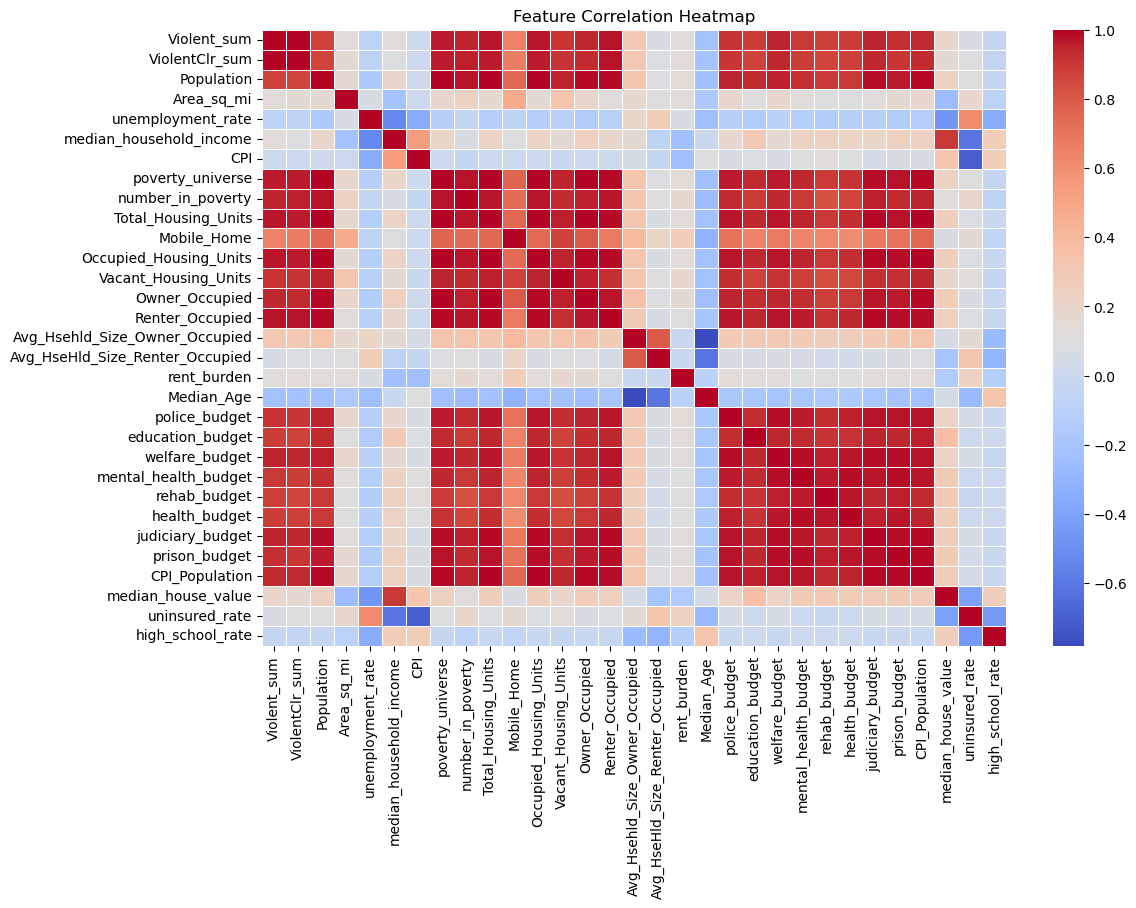

In [378]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

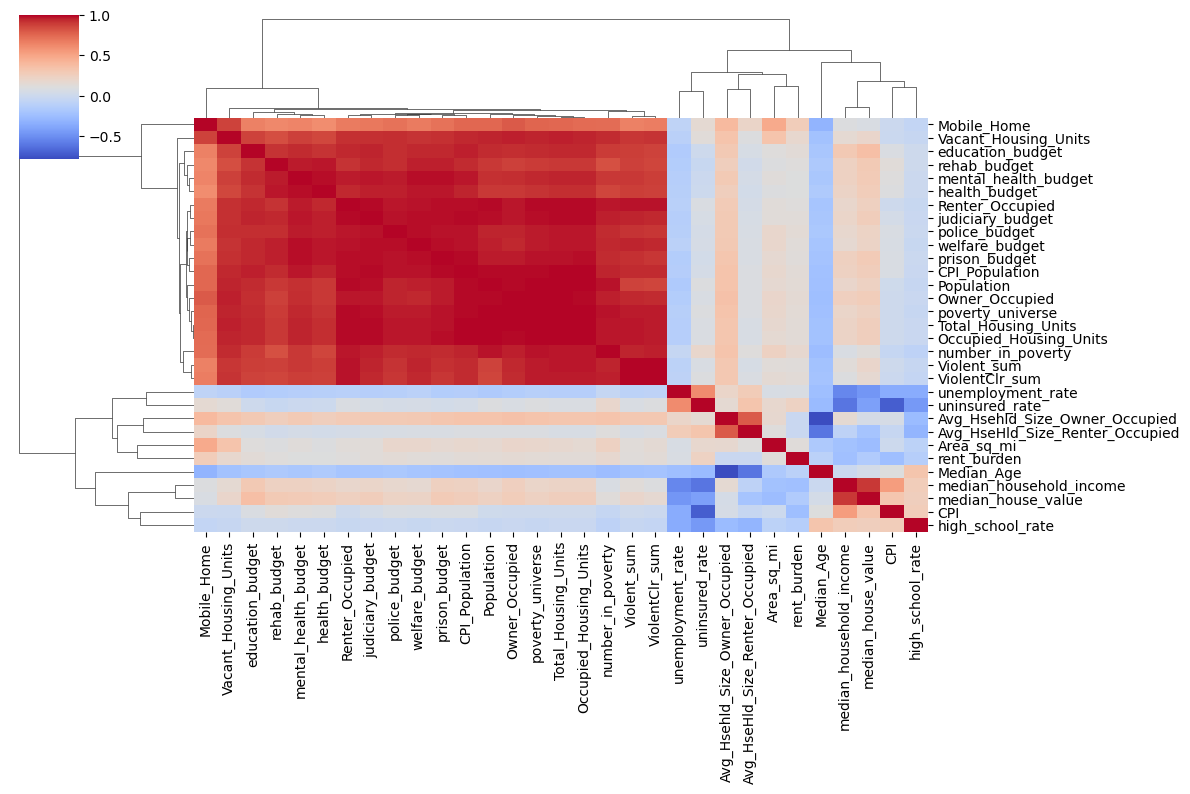

In [379]:
sns.clustermap(correlation_matrix, cmap="coolwarm", figsize=(12, 8))
plt.show()

## Computing rates

In [ ]:
def compute_crime_rate(df):
    """
    Computes the crime rate as Total Crimes per 1,000 people and adds it to the dataset.
    Parameters:
        data (pd.DataFrame): The input dataset.
    Returns:
        pd.DataFrame: The dataset with the crime rate as the target column.
    """
    data = df.copy()
    if "Violent_sum" in data.columns and "Population" in data.columns:
        data["crime_rate"] = data["Violent_sum"] / data["Population"]
        return data

    raise ValueError(
        "Columns 'Violent_sum' and 'Population' are required to compute the crime rate."
    )


def compute_clearance_rate(df):
    """
    Computes the clearance rate as ViolentClr_sum / Violent_sum.
    """
    data = df.copy()
    if "ViolentClr_sum" in data.columns and "Violent_sum" in data.columns:
        data["clearance_rate"] = data["ViolentClr_sum"] / data["Violent_sum"]
        # print("Computed .... clearance_rate")
    else:
        raise ValueError(
            "Columns 'ViolentClr_sum' and 'Violent_sum' are required for clearance rate."
        )
    return data


# Feature Function: Compute Population Density
def compute_population_density(df):
    """
    Computes the population density as Population / Area_sq_mi.
    """
    data = df.copy()
    if "Population" in data.columns and "Area_sq_mi" in data.columns:
        data["population_density"] = data["Population"] / data["Area_sq_mi"]
    else:
        raise ValueError(
            "Columns 'Population' and 'Area_sq_mi' are required for population density."
        )
    return data


# Dynamically Add Adjusted Expenditure Columns


def add_adjusted_expenditures(df):
    """
    Adjusts expenditure columns by CPI_Population.
    Parameters:
        data (pd.DataFrame): The input dataset.
    Returns:
        pd.DataFrame: The dataset with adjusted expenditure columns.
    """
    data = df.copy()
    if "CPI_Population" not in data.columns or (data["CPI_Population"] <= 0).any():
        raise ValueError(
            "CPI_Population column is missing or invalid (e.g., contains zero or NaN values)."
        )
    if all(
        col in data.columns
        for col in [
            "police_budget",
            "education_budget",
            "welfare_budget",
            "mental_health_budget",
            "rehab_budget",
            "health_budget",
            "judiciary_budget",
            "prison_budget",
        ]
    ):
        data["adj_police_budget"] = data["police_budget"] / data["CPI_Population"]
        data["adj_education_budget"] = data["education_budget"] / data["CPI_Population"]
        data["adj_welfare_budget"] = data["welfare_budget"] / data["CPI_Population"]
        data["adj_mental_health_budget"] = (
            data["mental_health_budget"] / data["CPI_Population"]
        )
        data["adj_rehab_budget"] = data["rehab_budget"] / data["CPI_Population"]
        data["adj_health_budget"] = data["health_budget"] / data["CPI_Population"]
        data["adj_judiciary_budget"] = data["judiciary_budget"] / data["CPI_Population"]
        data["adj_prison_budget"] = data["prison_budget"] / data["CPI_Population"]

        data["social_vs_security"] = (
            data["adj_education_budget"]
            + data["adj_welfare_budget"]
            + data["adj_health_budget"]
        ) / (
            data["adj_police_budget"]
            + data["adj_judiciary_budget"]
            + data["adj_prison_budget"]
        )
        data["security_vs_social"] = (
            data["adj_police_budget"]
            + data["adj_judiciary_budget"]
            + data["adj_prison_budget"]
        ) / (
            data["adj_education_budget"]
            + data["adj_welfare_budget"]
            + data["adj_health_budget"]
        )
    else:
        raise ValueError("Required columns for adjusted_expenditures are missing.")

    return data


# Feature Function: Adjusted Income
def compute_adjusted_income(df):
    """
    Computes adjusted income as median household income divided by CPI.
    """
    data = df.copy()
    if "median_household_income" in data.columns and "CPI" in data.columns:
        data["adjusted_income"] = data["median_household_income"] / data["CPI"]
    else:
        raise ValueError(
            "Columns 'median_household_income' and 'CPI' are required for adjusted income."
        )
    return data


# Feature Function: House Affordability
def compute_house_affordability(df):
    """
    Computes house affordability as median house value divided by median household income.
    """
    data = df.copy()
    if (
        "median_house_value" in data.columns
        and "median_household_income" in data.columns
    ):
        data["house_affordability"] = (
            data["median_house_value"] / data["median_household_income"]
        )
    else:
        raise ValueError(
            "Columns 'median_house_value' and 'median_household_income' are required for house affordability."
        )
    return data


# Feature Function: Home Ownership Rate
def compute_home_ownership_rate(df):
    """
    Computes home ownership rate as Owner_Occupied divided by Occupied_Housing_Units.
    """
    data = df.copy()
    if "Owner_Occupied" in data.columns and "Occupied_Housing_Units" in data.columns:
        data["home_ownership_rate"] = (
            data["Owner_Occupied"] / data["Occupied_Housing_Units"]
        )
    else:
        raise ValueError(
            "Columns 'Owner_Occupied' and 'Occupied_Housing_Units' are required for home ownership rate."
        )
    return data


# Feature Function: Total Persons and Household Metrics
def compute_persons_and_household_metrics(df):
    """
    Computes total persons, total persons for owners/renters, and persons per household.
    """
    data = df.copy()
    if all(
        col in data.columns
        for col in [
            "Vacant_Housing_Units",
            "Total_Housing_Units",
            "Owner_Occupied",
            "Avg_Hsehld_Size_Owner_Occupied",
            "Renter_Occupied",
            "Avg_HseHld_Size_Renter_Occupied",
            "Occupied_Housing_Units",
            "Mobile_Home",
        ]
    ):
        data["vacancy_rate"] = (
            data["Vacant_Housing_Units"] / data["Total_Housing_Units"]
        )
        data["Total_Persons_Owner"] = (
            data["Owner_Occupied"] * data["Avg_Hsehld_Size_Owner_Occupied"]
        )
        data["Total_Persons_Renter"] = (
            data["Renter_Occupied"] * data["Avg_HseHld_Size_Renter_Occupied"]
        )
        data["Total_Persons"] = (
            data["Total_Persons_Owner"] + data["Total_Persons_Renter"]
        )
        data["Number_of_Persons_per_HseHld"] = (
            data["Total_Persons"] / data["Occupied_Housing_Units"]
        )
        data["renter_ratio"] = data["Total_Persons_Renter"] / data["Total_Persons"]
        data["mobile_home_ratio"] = data["Mobile_Home"] / data["Total_Housing_Units"]
    else:
        raise ValueError(
            "Required columns for total persons or household metrics are missing."
        )
    return data

In [389]:
features_funcs = [
    compute_crime_rate,
    compute_clearance_rate,
    compute_population_density,
    add_adjusted_expenditures,
    compute_adjusted_income,
    compute_house_affordability,
    compute_home_ownership_rate,
    compute_mobile_home_ratio,
    compute_persons_and_household_metrics,
]

In [390]:
def apply_features(df, funcs):
    data = df.copy()

    for feature_func in funcs:
        data = feature_func(data)
    return data

In [391]:
test_df = apply_features(df=df_copy, funcs=features_funcs)

In [392]:
feature_0 = [
    "Population",
    "clearance_rate",
    "population_density",
    "unemployment_rate",
    "adjusted_income",
    "poverty_rate",
    "rent_burden",
    "home_ownership_rate",
    "mobile_home_ratio",
    "vacancy_rate",
    "renter_ratio",
    "Number_of_Persons_per_HseHld",
    "Median_Age",
    "adj_police_budget",
    "adj_education_budget",
    "adj_welfare_budget",
    "adj_mental_health_budget",
    "adj_rehab_budget",
    "adj_health_budget",
    "adj_judiciary_budget",
    "adj_prison_budget",
    "house_affordability",
    "uninsured_rate",
    "high_school_rate",
    "social_vs_security",
    "security_vs_social",
]
feature_cat = ["Category_Rural", "Category_Suburban", "Category_Urban"]

In [393]:
new_test_df = test_df[["County", "Year", "crime_rate"] + feature_0 + feature_cat]
# new_test_df=new_test_df.set_index(['County', 'Year'])
new_test_df.head()

County  Year  crime_rate  Population  clearance_rate  population_density  \
0  Alameda  1985    0.009809     1185500        0.466890         1606.368564   
1  Alameda  1986    0.010353     1206900        0.445778         1635.365854   
2  Alameda  1987    0.009588     1220600        0.538580         1653.929539   
3  Alameda  1988    0.008825     1242300        0.520660         1683.333333   
4  Alameda  1989    0.008375     1261200        0.497018         1708.943089   

   unemployment_rate  adjusted_income  poverty_rate  rent_burden  ...  \
0                NaN              NaN           NaN          NaN  ...   
1                NaN              NaN           NaN          NaN  ...   
2                NaN              NaN           NaN          NaN  ...   
3                NaN              NaN           NaN          NaN  ...   
4                NaN              NaN           NaN          NaN  ...   

   adj_judiciary_budget  adj_prison_budget  house_affordability  \
0                   NaN                NaN                  NaN   
1                   NaN                NaN                  NaN   
2                   NaN                NaN                  NaN   
3                   NaN                NaN                  NaN   
4                   NaN                NaN                  NaN   

   uninsured_rate  high_school_rate  social_vs_security  security_vs_social  \
0             NaN               NaN                 NaN                 NaN   
1             NaN               NaN                 NaN                 NaN   
2             NaN               NaN                 NaN                 NaN   
3             NaN               NaN                 NaN                 NaN   
4             NaN               NaN                 NaN                 NaN   

   Category_Rural  Category_Suburban  Category_Urban  
0               0                  0               1  
1               0                  0               1  
2               0                  0               1  
3               0                  0               1  
4               0                  0               1  

[5 rows x 32 columns]

In [394]:
new_test_df.columns

Index(['County', 'Year', 'crime_rate', 'Population', 'clearance_rate',
       'population_density', 'unemployment_rate', 'adjusted_income',
       'poverty_rate', 'rent_burden', 'home_ownership_rate',
       'mobile_home_ratio', 'vacancy_rate', 'renter_ratio',
       'Number_of_Persons_per_HseHld', 'Median_Age', 'adj_police_budget',
       'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability',
       'uninsured_rate', 'high_school_rate', 'social_vs_security',
       'security_vs_social', 'Category_Rural', 'Category_Suburban',
       'Category_Urban'],
      dtype='object')

In [408]:
new_test_df = new_test_df.set_index(["County", "Year"])

In [409]:
def fill_missing_with_linear_regression(group):
    """
    For a single county (group), fit a simple linear regression model
    Year vs. each numeric column. Use that model to fill missing values.
    """
    # Sort by Year for clarity
    group = group.sort_index(level="Year")

    # Iterate over each column
    for col in group.columns:
        # Only process numeric columns
        if pd.api.types.is_numeric_dtype(group[col]):
            # Extract the known data points (drop missing)
            valid_data = group[col].dropna()

            # If there aren't at least two valid points, we can't fit a regression
            if len(valid_data) < 2:
                continue

            # Prepare X (Year) and y (column values)
            X = valid_data.index.get_level_values("Year").values.reshape(-1, 1)
            y = valid_data.values

            # Fit the linear regression model
            model = LinearRegression().fit(X, y)

            # Predict for all years in this county
            X_all = group.index.get_level_values("Year").values.reshape(-1, 1)
            y_pred = model.predict(X_all)

            # Fill only missing values with the predictions
            missing_mask = group[col].isna()
            group.loc[missing_mask, col] = y_pred[missing_mask]

    return group


# 2. Group by County and apply the regression-based filling

In [410]:
df_reg_filled = new_test_df.groupby(level="County", group_keys=False).apply(
    fill_missing_with_linear_regression
)

df_reg_filled.head(10)

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   
        1990    0.009106     1276702        0.470067         1729.948509   
        1991    0.012014     1284782        0.386848         1740.897019   
        1992    0.012856     1302709        0.377120         1765.188347   
        1993    0.013388     1318127        0.374115         1786.079946   
        1994    0.012262     1327526        0.398820         1798.815718   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985           5.890887       198.249497     20.616190    49.471868   
        1986           5.887444       202.918528     20.301905    49.215165   
        1987           5.884002       207.587558     19.987619    48.958462   
        1988           5.880559       212.256589     19.673333    48.701758   
        1989           5.877117       216.925620     19.359048    48.445055   
        1990           5.873674       221.594651     19.044762    48.188352   
        1991           5.500000       226.263681     18.730476    47.931648   
        1992           6.600000       230.932712     18.416190    47.674945   
        1993           6.700000       235.601743     18.101905    47.418242   
        1994           6.200000       240.270774     17.787619    47.161538   

              home_ownership_rate  mobile_home_ratio  ...  \
County  Year                                          ...   
Alameda 1985             0.541511           0.013777  ...   
        1986             0.541334           0.013726  ...   
        1987             0.541157           0.013674  ...   
        1988             0.540979           0.013623  ...   
        1989             0.540802           0.013572  ...   
        1990             0.540625           0.013520  ...   
        1991             0.540447           0.013469  ...   
        1992             0.540270           0.013417  ...   
        1993             0.540093           0.013366  ...   
        1994             0.539915           0.013315  ...   

              adj_judiciary_budget  adj_prison_budget  house_affordability  \
County  Year                                                                 
Alameda 1985              0.607080           0.349449             6.598017   
        1986              0.603444           0.360553             6.625489   
        1987              0.599807           0.371658             6.652962   
        1988              0.596171           0.382763             6.680434   
        1989              0.592534           0.393867             6.707907   
        1990              0.588898           0.404972             6.735380   
        1991              0.585261           0.416077             6.762852   
        1992              0.581625           0.427181             6.790325   
        1993              0.577989           0.438286             6.817797   
        1994              0.574352           0.449390             6.845270   

              uninsured_rate  high_school_rate  social_vs_security  \
County  Year                                                         
Alameda 1985        0.359035         53.839341            2.132060   
        1986        0.350230         54.807253            2.135405   
        1987        0.341424         55.775165            2.138751   
        1988        0.332619         56.743077            2.142097   
        1989        0.323813         57.710989            2.14

In [411]:
df_reg_filled.columns

Index(['crime_rate', 'Population', 'clearance_rate', 'population_density',
       'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden',
       'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate',
       'renter_ratio', 'Number_of_Persons_per_HseHld', 'Median_Age',
       'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability',
       'uninsured_rate', 'high_school_rate', 'social_vs_security',
       'security_vs_social', 'Category_Rural', 'Category_Suburban',
       'Category_Urban'],
      dtype='object')

In [412]:
df_reg_filled.columns[df_reg_filled.isnull().any()].tolist()

['adj_police_budget',
 'adj_education_budget',
 'adj_welfare_budget',
 'adj_mental_health_budget',
 'adj_rehab_budget',
 'adj_health_budget',
 'adj_judiciary_budget',
 'adj_prison_budget',
 'house_affordability',
 'social_vs_security',
 'security_vs_social']